In [1]:
import nidaqmx
import time
from santectsl570 import SantecTSL570
import matplotlib.pyplot as plt
import numpy as np
import qontrol
import sys
import time
import numpy as np
import functions as func

In [2]:
# Connection to instruments
laser = SantecTSL570("GPIB0::19::INSTR")
task = nidaqmx.Task()  # Instantiate the NI DAQ
q = qontrol.QXOutput(serial_port_name = "COM3", response_timeout = 0.1)

# Qontrol
print ("Qontroller '{:}' initialised with firmware {:} and {:} channels".format(q.device_id, q.firmware, q.n_chs) )
i_max = 14
ivals = [float(x) for x in np.linspace(0, i_max, 25)]
ch = 46

# Nidaq
task.ai_channels.add_ai_voltage_chan("Dev1/ai2")  # Read out and add the voltage of the channel AI0 which corresponds to Out(1,0)
sampling_rate = 200000
n_sample = 50

# Laser
start_wl = 1549
stop_wl = 1551
wl = start_wl



wavelengths = []  # List to store wavelengths
intensities = []  # List to store intensities

for ival in ivals:
    q.i[ch] = ival
    laser.set_wavelength(start_wl)
    wl = start_wl
    time.sleep(0.2)
    print(f"current to be set :{ival}")
    print(f"channel {ch} voltage {q.v[ch]} current {q.i[ch]}")
    intensities_temp = []
    wavelengths = []
    try:
        while wl < stop_wl:
            
            # Configure the sampling
            task.timing.cfg_samp_clk_timing(rate=sampling_rate, samps_per_chan=n_sample)
            # Read out the task
            voltage = task.read(number_of_samples_per_channel=n_sample)
            
            # Calculate and append the mean data value
            mean_value = np.mean(voltage)
            intensities_temp.append(mean_value)  # Append intensity
            print(f"Wavelength: {wl} nm, Intensity: {mean_value}")

            wavelengths.append(wl)  # Append current wavelength        
            # Update the wavelength and wait
            wl += 0.01  # nm
            laser.set_wavelength(wl)
            time.sleep(0.01)
        intensities.append(intensities_temp)

    except Exception as e:
        print(f"An error occurred: {e}")

task.close()  # Close the DAQ task
q.v[:] = 0
q.close()

Driver thresholds set @ 12 V , 20 mA
Qontroller 'Q8iv-00B1' initialised with firmware v2.3.7 and 96 channels
current to be set :0.0
channel 46 voltage -0.0002 current -0.0083
Wavelength: 1549 nm, Intensity: 0.0028728444556875977
Wavelength: 1549.01 nm, Intensity: 0.0026589469176845925
Wavelength: 1549.02 nm, Intensity: 0.0024615030364979556
Wavelength: 1549.03 nm, Intensity: 0.0022146981850762093
Wavelength: 1549.04 nm, Intensity: 0.002033707960747668
Wavelength: 1549.05 nm, Intensity: 0.0018691713932082255
Wavelength: 1549.06 nm, Intensity: 0.0016914719003053857
Wavelength: 1549.07 nm, Intensity: 0.0014940280193387946
Wavelength: 1549.08 nm, Intensity: 0.001316328526511104
Wavelength: 1549.09 nm, Intensity: 0.0011452104964165695
Wavelength: 1549.1 nm, Intensity: 0.001023453436555937
Wavelength: 1549.11 nm, Intensity: 0.0008918241826760229
Wavelength: 1549.12 nm, Intensity: 0.0007898115109409809
Wavelength: 1549.1299999999999 nm, Intensity: 0.0006417286003723219
Wavelength: 1549.139999

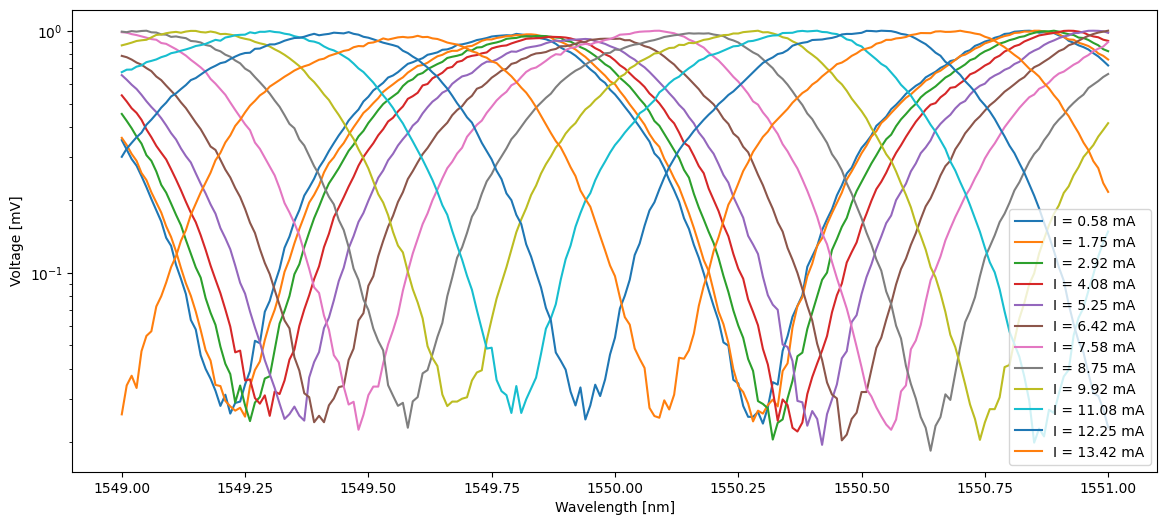

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot each list in L using a for loop
for i, data in enumerate(intensities):
    label = f'I = {ivals[i]:.2f} mA'
    norm_data = np.array(data) / np.array(data).max()
    if i%2:
        plt.semilogy(np.array(wavelengths), norm_data, label=label)

# Add labels and a legend
plt.ylabel('Voltage [mV]')
plt.xlabel('Wavelength [nm]')
plt.legend()

# Show the plot
plt.show()


In [5]:

def device_crosstalk(device_name,intensities, ivals, device_distance, sweep_wavelength):
    device_info = {
        "device_name"      : device_name,
        "intensities"      : intensities,
        "ivals"            : ivals,
        "device_distance"  : device_distance,
        "sweep_wavelength" : sweep_wavelength
    }
    return device_info
sweep_wavelength = np.arange(start_wl, stop_wl, 0.01)
device_to_save = device_crosstalk(device_name="device3", intensities=intensities, ivals=ivals, device_distance=225, sweep_wavelength=sweep_wavelength)

In [50]:
data_folder = "test_structures\\crosstalk\\s105\\"
func.save_dict_custom(device_to_save,data_folder)

Data saved to .data\test_structures\crosstalk\s105\device3_0.pkl


In [35]:
import importlib
importlib.reload(func)

<module 'functions' from 'c:\\Users\\QPG\\Downloads\\Marseille\\Marseille\\functions.py'>

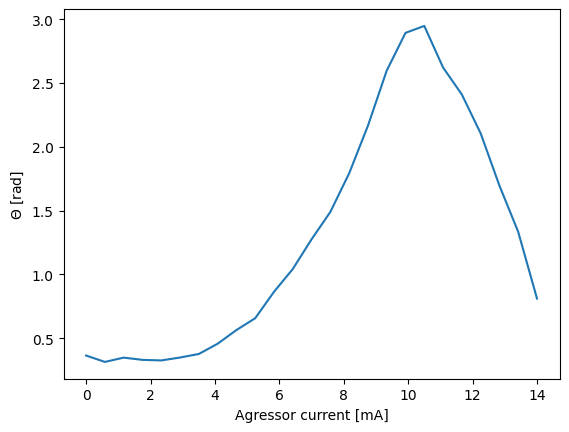

In [7]:
def theta(P):
    return 2*np.arcsin(np.sqrt(P))

normalized_intensities = [np.array(data[50:150])/np.array(data[50:150]).max() for data in intensities]
normalized_wavelength  = wavelengths[50:150]
theta_list = []
for i,intensity in enumerate(normalized_intensities):
    theta_list.append(theta(intensity[80]))

plt.plot(ivals,theta_list)
plt.xlabel("Agressor current [mA]")
plt.ylabel("$\\Theta$ [rad]")
plt.show()